#### get ERA5 SST, RH, Vorticity time series according to LMI and plot composit maps 
- SST
- Relative humidity at 600hPa
- relative vorticity at 850hPa <br>

Ming Ge June 2024

In [22]:
import calendar
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [23]:
def plot_2d(lat, lon, data_2d, vmin, vmax, color_map, title_s, label_unit):
    fig = plt.figure(figsize=(10, 8))

    # Set the axes using the specified map projection
    ax=plt.axes(projection=ccrs.PlateCarree())
    
    # Make a filled contour plot
    filled_c = ax.contourf(lon, lat, data_2d, 
                           levels =np.linspace(vmin, vmax, num=11), extend='both',
                           cmap = color_map, transform = ccrs.PlateCarree())

    # Add coastlines
    ax.coastlines()
    ax.add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
    ax.set_title(title_s)
    
    ax = plt.gca()
    ax.gridlines(draw_labels=True)   
    # or..
    #ax.set_xticks([-40, -20, 0, 20, 40], crs=ccrs.PlateCarree())

    # Add a colorbar for the filled contour.
    # and pad argument to set colorbar away from x-axis
    fig.colorbar(filled_c,  label= label_unit, pad = 0.05, fraction=0.04, orientation="horizontal"); # 

#### set up

In [24]:
lag = 2

#  averaging radius in degrees
rr = .5

#### read in lmi times/locations

In [25]:
flnm = '/glade/work/done/tc_int/Kossin_LMIs_cut.csv'
df_lmi = pd.read_csv(flnm, delimiter=',', engine='python')

yyyy = df_lmi.kyear.values 
mm   = df_lmi.kmon.values
dd   = df_lmi.kday.values
hh   = df_lmi.khour.values

yyyys = yyyy.astype(str)
mms   = mm.astype(str)
dds   = dd.astype(str)
hhs   = hh.astype(str)

ntim = len(hhs)

yyyymmddhh = [None] * ntim
date_format = '%Y%m%d%H'

for nt in range(ntim):
    current_date = datetime(yyyy[nt], mm[nt], dd[nt], hh[nt])
    
    # Calculate the date of the previous 2 days
    datetime_lagged = current_date - timedelta(days=lag)

    yyyys[nt] = str(datetime_lagged.year).zfill(2)
    mms[nt]   = str(datetime_lagged.month).zfill(2)
    dds[nt]   = str(datetime_lagged.day).zfill(2)
    hhs[nt]   = str(datetime_lagged.hour).zfill(2)
    yyyymmddhh[nt] = yyyys[nt] + mms[nt] + dds[nt] + hhs[nt]
df_lmi.head()

,ksid300,lmi,kyear,kmon,kday,khour,klat,klon
0,1979002S04179,105,1979,1,6,12,-14.61,166.52
1,1979008S14137,50,1979,1,10,0,-12.91,141.48
2,1979027S15167,55,1979,2,1,0,-16.60,170.08
3,1979031S12056,60,1979,2,10,0,-25.15,71.59
4,1979033S18151,65,1979,2,4,0,-15.85,166.15


In [26]:
# E5 is on a quarter degree lat lon. Need to round to the nearest quarter to get the same dimensions for compositing.
lat = np.round(df_lmi.klat.values*4.0, 0)/4.0
lon = df_lmi.klon.values
lon = np.where(lon <= 0., lon+360., lon)
lon = np.round(lon*4.0, 0)/4.0 
vmax = df_lmi.lmi.values
lat.min(), lat.max(),lon.min(), lon.max()

(-43.0, 58.5, 33.0, 341.0)

#### get SST from ERA5

output /glade/derecho/scratch/mingge/ERA5/global_lmi_e5_lag2d_0.5radius_sst.nc


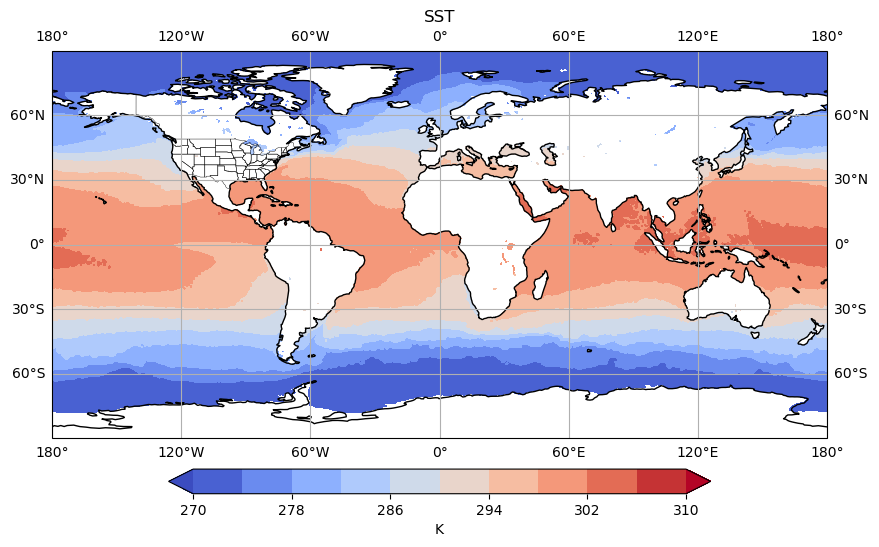

In [31]:
dir_sfc = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.sfc/"
ntim = 100
sst_1d = np.zeros((ntim))

is_first = True
ct = 1
for nt in range(ntim):
    dir = dir_sfc + yyyys[nt] + mms[nt] + "/" 
    last_day = str(calendar.monthrange(int(yyyys[nt]), int(mms[nt]))[1])
    flnm = dir + "e5.oper.an.sfc.128_034_sstk.ll025sc." + yyyys[nt] + mms[nt] + "0100_" + yyyys[nt] + mms[nt] + last_day.zfill(2)+ "23.nc"
    #print(nt, ntim, flnm)

    # Converting a string in a specific format to a datetime
    date_obj = datetime.strptime(yyyymmddhh[nt], date_format)
    
    with xr.open_dataset(flnm) as ds:
        sst_1d[nt] = ds.SSTK.sel(time = date_obj,
                                 latitude=slice(lat[nt]+rr, lat[nt]-rr), 
                                 longitude=slice(lon[nt]-rr,lon[nt]+rr)).mean()
        if is_first == True: 
            sst_2d = ds.SSTK.sel(time = date_obj)
            is_first = False
        else:
            ct = ct + 1
            sst_2d = sst_2d + ds.SSTK.sel(time = date_obj)
        
sst_da = xr.DataArray(sst_1d, dims=("time"), coords={"time":yyyymmddhh[:ntim]})
sst_2d = sst_2d/ct
ds =  xr.Dataset({"sst_ts":sst_da, "sst_mean":sst_2d}) 
 
dir_o = '/glade/derecho/scratch/mingge/ERA5/'
flnm_o = dir_o + 'global_lmi_e5_lag' + str(lag) + 'd_' + str(rr) + "radius_sst.nc"
print('output', flnm_o)
ds.to_netcdf(flnm_o)    
plot_2d(ds.latitude, ds.longitude, sst_2d, 270, 310, 'coolwarm', 'SST', 'K')

####  Relative humidity at 600hPa

output /glade/derecho/scratch/mingge/ERA5/global_lmi_e5_lag2d_0.5radius_rh.nc
CPU times: user 3min 8s, sys: 23.8 s, total: 3min 32s
Wall time: 5min 13s


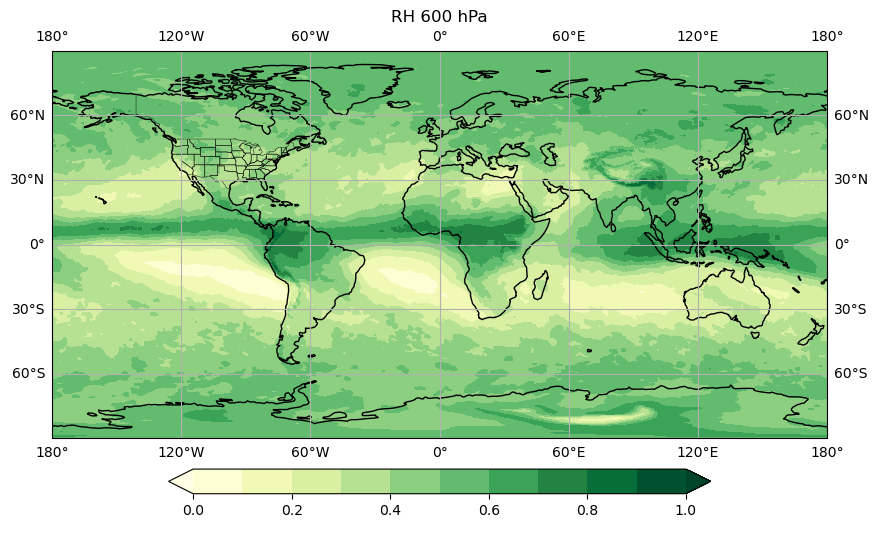

In [33]:
%%time
dir_pl = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/"
ntim = 100
rh_1d = np.zeros((ntim))

is_first = True
ct = 1
for nt in range(ntim):
    dir = dir_pl + yyyys[nt] + mms[nt] + "/" 
    # units = "kg kg**-1" 
    flnm_q = dir + "e5.oper.an.pl.128_133_q.ll025sc." + yyyys[nt] + mms[nt] + dds[nt] + "00_" + yyyys[nt] + mms[nt] + dds[nt] + "23.nc"
    # units = "K" 
    flnm_t = dir + "e5.oper.an.pl.128_130_t.ll025sc." + yyyys[nt] + mms[nt] + dds[nt] + "00_" + yyyys[nt] + mms[nt] + dds[nt] + "23.nc"
      
    #print(nt, ntim, flnm_t)

    # Converting a string in a specific format to a datetime
    date_obj = datetime.strptime(yyyymmddhh[nt], date_format)
    with xr.open_dataset(flnm_q) as ds:
        qq = ds.Q.sel(time = date_obj, level=600)

    with xr.open_dataset(flnm_t) as ds:
        tt = ds.T.sel(time = date_obj, level=600)
         
    pres = tt.copy()
    pres[:] = 600
    rh_tmp = relative_humidity_from_specific_humidity(pres.values*units.hPa, tt, qq) 
    
    if is_first == True: 
        rh_2d = rh_tmp
        is_first = False
    else:
        ct = ct + 1
        rh_2d = rh_2d + rh_tmp       

    rh_1d[nt] = rh_tmp.sel(latitude=slice(lat[nt]+rr, lat[nt]-rr), 
                    longitude=slice(lon[nt]-rr,lon[nt]+rr)).mean()
   
## write out
rh_da = xr.DataArray(rh_1d, dims=("time"), coords={"time":yyyymmddhh[:ntim]})
rh_2d = rh_2d/ct
ds =  xr.Dataset({"rh_ts":rh_da, "rh_mean":rh_2d}) 
 
dir_o = '/glade/derecho/scratch/mingge/ERA5/'
flnm_o = dir_o + 'global_lmi_e5_lag' + str(lag) + 'd_' + str(rr) + "radius_rh.nc"
print('output', flnm_o)
ds.to_netcdf(flnm_o)       
plot_2d(ds.latitude, ds.longitude, rh_2d, 0, 1, 'YlGn', 'RH 600 hPa', ' ')

#### Relative vorticity at 850hPa

output /glade/derecho/scratch/mingge/ERA5/global_lmi_e5_lag2d_0.5radius_vor.nc
CPU times: user 3min 23s, sys: 18 s, total: 3min 41s
Wall time: 4min 43s


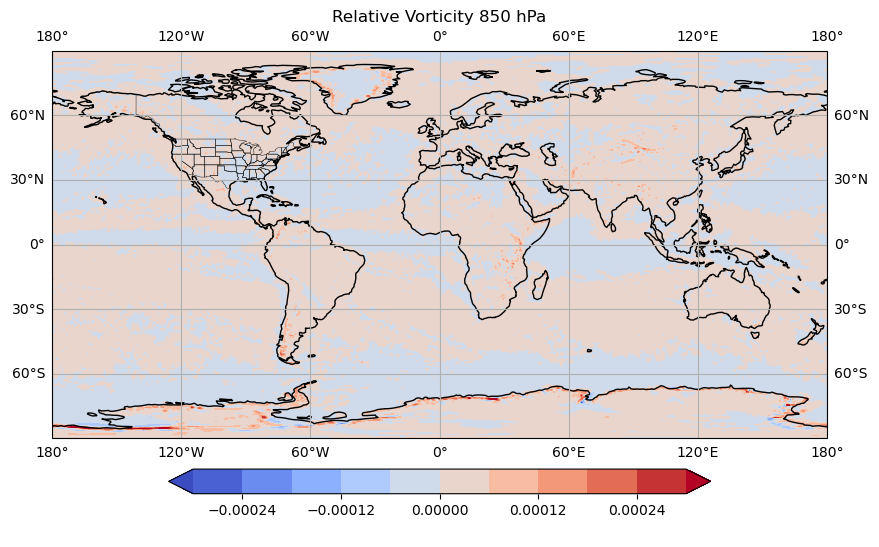

In [35]:
%%time
dir_pl = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/"
ntim = 100
vor_1d = np.zeros((ntim))

is_first = True
ct = 1
for nt in range(ntim):
    dir = dir_pl + yyyys[nt] + mms[nt] + "/" 
    # units = "kg kg**-1" 
    flnm_vo = dir + "e5.oper.an.pl.128_138_vo.ll025sc." + yyyys[nt] + mms[nt] + dds[nt] + "00_" + yyyys[nt] + mms[nt] + dds[nt] + "23.nc"       
    #print(nt, ntim, flnm_vo)

    # Converting a string in a specific format to a datetime
    date_obj = datetime.strptime(yyyymmddhh[nt], date_format)
    with xr.open_dataset(flnm_vo) as ds:
        vor_tmp = ds.VO.sel(time = date_obj, level=850)
 
    if is_first == True: 
        vor_2d = vor_tmp
        is_first = False
    else:
        ct = ct + 1
        vor_2d = vor_2d + vor_tmp  

    vor_1d[nt] = vor_tmp.sel(latitude=slice(lat[nt]+rr, lat[nt]-rr), 
                    longitude=slice(lon[nt]-rr,lon[nt]+rr)).mean()
   
vor_da = xr.DataArray(rh_1d, dims=("time"), coords={"time":yyyymmddhh[:ntim]})
vor_2d = vor_2d/ct
ds =  xr.Dataset({"vor_ts":vor_da, "vor_mean":vor_2d}) 
 
dir_o = '/glade/derecho/scratch/mingge/ERA5/'
flnm_o = dir_o + 'global_lmi_e5_lag' + str(lag) + 'd_' + str(rr) + "radius_vor.nc"
print('output', flnm_o)
ds.to_netcdf(flnm_o) 
    
plot_2d(ds.latitude, ds.longitude, vor_2d, -0.0003, 0.0003, 'coolwarm', 'Relative Vorticity 850 hPa', ' ')


In [ ]:
plot_2d(ds.latitude, ds.longitude, vor_2d, -0.0001, 0.0001, 'coolwarm', 'Relative Vorticity 850 hPa', ' ')